# Clasificación útilizando aprendizaje de máquinas

En aprendizaje de máquinas, la regresión es la tarea de identificar a qué valor continuo una observación nueva pertenece, tomando como base un entrenamiento previo sobre un grupo de observaciones donde sí se conocían sus valores continuos correspondientes.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.ensemble
import sklearn.linear_model
import sklearn.neighbors
import sklearn.dummy

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


Para entrenar y probar los modelos de regressión, utilizaremos un conjunto de datos que contiene valores de seguros de salud junto con características al paciente asociado al seguro.

In [2]:
data = pd.read_csv("data/insurance.csv")

In [3]:
data

,age,female,bmi,children,smoker,charges
0,19,1,27.900,0,1,16884.92400
1,18,0,33.770,1,0,1725.55230
2,28,0,33.000,3,0,4449.46200
3,33,0,22.705,0,0,21984.47061
4,32,0,28.880,0,0,3866.85520
...,...,...,...,...,...,...
1333,50,0,30.970,3,0,10600.54830
1334,18,1,31.920,0,0,2205.98080
1335,18,1,36.850,0,0,1629.83350
1336,21,1,25.800,0,0,2007.94500


In [4]:
data.head()

,age,female,bmi,children,smoker,charges
0,19,1,27.900,0,1,16884.92400
1,18,0,33.770,1,0,1725.55230
2,28,0,33.000,3,0,4449.46200
3,33,0,22.705,0,0,21984.47061
4,32,0,28.880,0,0,3866.85520


Verificamos con el método pandas.DataFrame.describe() que las variables no tienen el mismo rango, por lo que seria necesario reescalarlas.

In [5]:
data.describe()

,age,female,bmi,children,smoker,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.494768,30.663397,1.094918,0.204783,13270.422265
std,14.049960,0.500160,6.098187,1.205493,0.403694,12110.011237
min,18.000000,0.000000,15.960000,0.000000,0.000000,1121.873900
25%,27.000000,0.000000,26.296250,0.000000,0.000000,4740.287150
50%,39.000000,0.000000,30.400000,1.000000,0.000000,9382.033000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,16639.912515
max,64.000000,1.000000,53.130000,5.000000,1.000000,63770.428010


In [6]:
data.shape # Obtenemos las dimensiones de nuestro conjunto de datos.

(1338, 6)

Para obtener una intuición general de las relaciones que existen entre variables, una práctica habitual es evaluar la correlación que existe entre las variables, sobretodo la correlación que existe entre las características y la etiqueta. Para esto utilizamos indicadores de estadística clásica como es el coeficiente de correlación de Pearson o Spearman.

In [7]:
correlation = data.corr() # Por defecto este método calcula la correlación de Pearson.
correlation

,age,female,bmi,children,smoker,charges
age,1.000000,0.020856,0.109272,0.042469,-0.025019,0.299008
female,0.020856,1.000000,-0.046371,-0.017163,-0.076185,-0.057292
bmi,0.109272,-0.046371,1.000000,0.012759,0.003750,0.198341
children,0.042469,-0.017163,0.012759,1.000000,0.007673,0.067998
smoker,-0.025019,-0.076185,0.003750,0.007673,1.000000,0.787251
charges,0.299008,-0.057292,0.198341,0.067998,0.787251,1.000000


<AxesSubplot:>

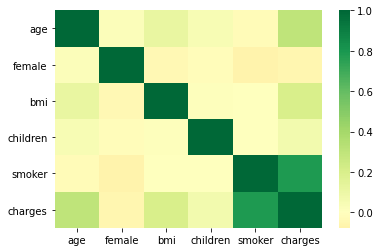

In [8]:
sns.heatmap(
    correlation,
    cmap="RdYlGn", # Utilizamos una paleta de colores divergente para visualizar diferencias en los valores positivos y negativos
    center = 0
) # Utilizamos seaborn para visualizar un mapa de calor de las correlaciones.

También podemos visualizar en un gráfico de dispersión cómo se correlacionan las características.

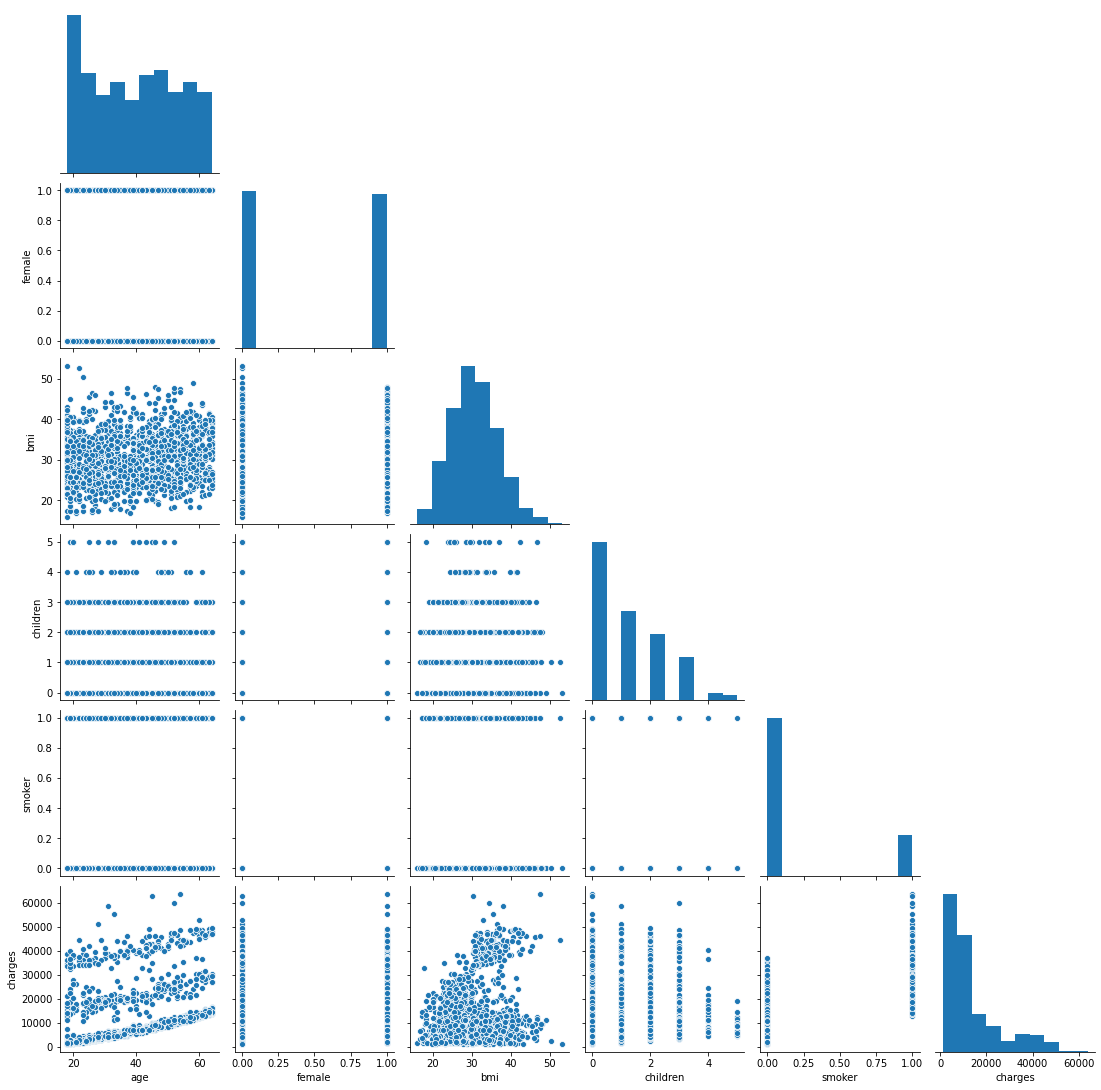

In [9]:
sns.pairplot(data, corner=True)

Exploramos en detalle la variable que más se correlaciona con el valor del seguro de salud.

Se observa que claramente hay una diferencia del valor del seguro en cada grupo

<AxesSubplot:xlabel='smoker', ylabel='charges'>

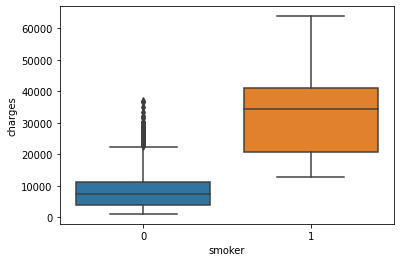

In [10]:
sns.boxplot(
    data = data,
    x="smoker",
    y="charges"
)

Confirmamos la diferencia con una prueba estadística.

In [11]:
scipy.stats.ttest_ind(*data.groupby(by="smoker")["charges"].apply(list))

Ttest_indResult(statistic=-46.66492117272371, pvalue=8.271435842179102e-283)

## Preprocesamiento

In [12]:
features = data.iloc[:,:-1]
feature_names = features.columns

In [13]:
label = data.charges

Los algoritmos para entrenar modelos de aprendizaje de máquinas no se comportan bien en su mayoría con diferencias en los rangos de valores de sus características, por lo que es siempre una buena práctica reescalar los valores hacia un rango predeterminado.

In [14]:
scaler = sklearn.preprocessing.MinMaxScaler() # Instanciamos la clase del scaler que realizará una normalización de los datos
features[:] = scaler.fit_transform(features) # Ajustamos el scaler y al mismo tiempo transformamos nuestras características

In [15]:
features.describe()

,age,female,bmi,children,smoker
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,0.461022,0.494768,0.395572,0.218984,0.204783
std,0.305434,0.500160,0.164062,0.241099,0.403694
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.195652,0.000000,0.278080,0.000000,0.000000
50%,0.456522,0.000000,0.388485,0.200000,0.000000
75%,0.717391,1.000000,0.504002,0.400000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
features_train, features_test, label_train, label_test = sklearn.model_selection.train_test_split( 
    features,
    label,
    test_size=0.30, 
    random_state = 11, 
)

## Modelamiento

Para evaluar el rendimiento de nuestro modelos sobre el conjunto de prueba debemos utilizar métricas distintas a las que usábamos en clasificación. sklearn nos ofrece una serie de métricas especificas para regresión, las cuales se encuentran todas descritas en la documentación https://scikit-learn.org/stable/modules/model_evaluation.html .

In [17]:
def regression_report(y_true, y_pred):
    """
    Esta función recibe un arreglo de valores reales y predichos para 
    retornar un diccionario con una serie de métricas de regresión
    """
    return {
        'mae': sklearn.metrics.mean_absolute_error(y_true, y_pred),
        'rmse': sklearn.metrics.mean_squared_error(y_true, y_pred) ** 0.5,
        'r2': sklearn.metrics.r2_score(y_true, y_pred)
    }


### Regresión lineal

In [18]:
lr = sklearn.linear_model.LinearRegression()
lr.fit(features_train, label_train)

LinearRegression()

In [19]:
lr_predictions = lr.predict(features_test)

In [20]:
lr_vil = pd.DataFrame(lr.coef_,columns=["value"]) # Guardamos en un dataframe los coeficientes
lr_vil.index = feature_names
lr_vil

,value
age,12080.581801
female,259.556448
bmi,12553.371972
children,3181.457468
smoker,23646.673901


In [21]:
lr_regression_report = regression_report(label_test, lr_predictions)
lr_regression_report

{'mae': 4050.6577242974345,
 'rmse': 5729.313129379182,
 'r2': 0.7661228779513265}

### k-Nearest Neighbors

In [22]:
knn = sklearn.neighbors.KNeighborsRegressor() # Instanciamos una support vector machine con un kernel lineal
knn.fit(features_train, label_train)

KNeighborsRegressor()

In [23]:
knn_predictions = knn.predict(features_test)

In [24]:
knn_regression_report = regression_report(label_test, knn_predictions)
knn_regression_report

{'mae': 2922.617551350746, 'rmse': 5025.879662700733, 'r2': 0.8200272324464487}

### Random Forest

In [25]:
rf = sklearn.ensemble.RandomForestRegressor()
rf.fit(features_train, label_train)

RandomForestRegressor()

In [26]:
rf_predictions = rf.predict(features_test)

In [27]:
rf_vil = pd.DataFrame(list(zip(feature_names,rf.feature_importances_)),
             columns=["feature","importance"]
            ).set_index("feature")
rf_vil.sort_values("importance",ascending=False)

,importance
feature,
smoker,0.602083
bmi,0.229566
age,0.138958
children,0.023114
female,0.006279


In [28]:
rf_regression_report = regression_report(label_test, rf_predictions)
rf_regression_report

{'mae': 2675.162071621144, 'rmse': 4817.030043196486, 'r2': 0.834673933346813}

### Regresor tonto

In [29]:
dummy = sklearn.dummy.DummyRegressor()
dummy.fit(features_train, label_train)

DummyRegressor()

In [30]:
dummy_predictions = dummy.predict(features_test)

In [31]:
dummy_regression_report = regression_report(label_test, dummy_predictions)
dummy_regression_report

{'mae': 9022.285193218884,
 'rmse': 11850.321704740843,
 'r2': -0.0005594643625606022}

## Resumen

Evaluemos cuál fue el modelo que tuvo el mejor rendimiento en cada una de las métricas.

In [32]:
performances = pd.DataFrame( # Consolidamos todas las métricas en un DatFrame
    data = [
        lr_regression_report,
        knn_regression_report,
        rf_regression_report,
        dummy_regression_report
    ],
    index = [
        "Linear Regression",
        "k-Nearest Neighbors",
        "Random Forest",
        "Regresor Tonto"
    ]
).sort_values( # Ordenamos los valores
    by="rmse"
)
performances

,mae,rmse,r2
Random Forest,2675.162072,4817.030043,0.834674
k-Nearest Neighbors,2922.617551,5025.879663,0.820027
Linear Regression,4050.657724,5729.313129,0.766123
Regresor Tonto,9022.285193,11850.321705,-0.000559


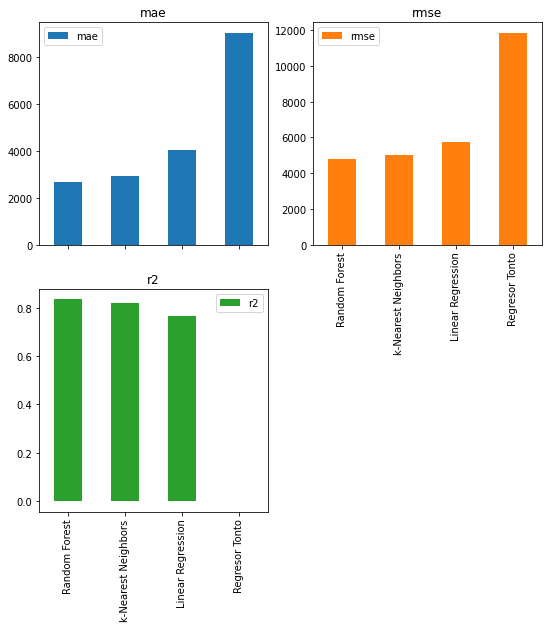

In [33]:
performances.plot.bar(
    subplots=True,
    layout=(2,2),
    figsize=(9,9)
)
plt.show()